In [ ]:
import pandas as pd
import numpy as np
# import lr

# 读取数据


## 选出对应患者24h内的数据

In [5]:
cxr = pd.read_csv("mimic-iv-cxr-2/mimic-cxr-2.0.0-metadata.csv", index_col=0)

In [24]:
# cxr = pd.read_csv("mimic-iv-cxr-2/train_set.csv", index_col=0)
# admission = pd.read_csv("mimic-iv-2/hosp/admissions.csv", header=0)
# admission = pd.merge(admission, cxr[["subject_id", "hadm_id", "label"]])
# admission["first_day"] = [i[0:11].replace("-","") for i in admission["admittime"]]
# lab = pd.read_csv("mimic-iv-2/hosp/labevents.csv")
# lab_d = pd.merge(admission[["subject_id", "first_day"]], lab)
# lab_d["time"] = [i[0:11].replace("-","") for i in lab_d["charttime"]]
# lab_d["hadm_id"] = lab_d["hadm_id"].fillna(0)
# lab_d["hadm_id"] =[int(i) for i in lab_d["hadm_id"]]
# lab_d["time_re"] = lab_d["first_day"].astype(int) - lab_d["time"].astype(int) 
# lab_d = lab_d.loc[(lab_d["time_re"]>=-1) & (lab_d["time_re"]<=1)] # 入院时间和检测时间相差1天内的
# lab_d.to_csv("predict_model/labevents.csv")

In [2]:
# 选出患者足够量的数据
lab_d = pd.read_csv("predict_model/labevents.csv", index_col=0)
# a = lab_d[['subject_id','hadm_id',"time_re"]].groupby(["subject_id","hadm_id"]).agg("max").reset_index()
lab_d = lab_d.loc[(lab_d["time_re"]==0)] # 入院时间和检测时间相差1天内的
lab_dd = lab_d[['subject_id','hadm_id','itemid', 'time', 'valuenum']]
lab_dd = lab_dd.loc[~lab_dd["valuenum"].isnull()].drop_duplicates()
effect_item = lab_dd["itemid"].value_counts()[lab_dd["itemid"].value_counts() > 1000]
lab_dd = lab_dd.loc[lab_dd["itemid"].isin(effect_item.index)]
lab_dd = lab_dd.groupby(["subject_id","hadm_id","time","itemid"]).agg('mean')
lab_dd = lab_dd.reset_index()
lab_dd["index"] = lab_dd["subject_id"].astype(str) + "_" + lab_dd["time"].astype(str)
lab_dd = lab_dd.pivot(index=["subject_id","hadm_id", "time"],columns='itemid',values="valuenum").reset_index()
d_lab = pd.read_csv("mimic-iv-2/hosp/d_labitems.csv")
new_idx  = list(lab_dd.columns[0:3])
new_idx.extend([d_lab.loc[d_lab["itemid"]==i,"label"].iloc[0] for i in lab_dd.columns[3:]])
lab_dd.columns = new_idx


In [3]:
# 添加CXR数据
cxr = pd.read_csv("mimic-iv-cxr-2/prediction_10fold.csv")
cxr.columns =['study_id', 'prediction', 'rate', 'cut'] 
cxr_train = pd.read_csv("mimic-iv-cxr-2/train_set.csv", index_col=0)
cxr_prediction = pd.merge(cxr_train,cxr)

In [4]:
cxr_code = pd.read_csv("mimic-iv-cxr-2/mimic-cxr-2.0.0-chexpert.csv")
cxr_code = cxr_code.fillna(0)
for i in cxr_code.columns:  
    cxr_code.loc[cxr_code[i]==-1] = 1
cxr_em = pd.merge(cxr, cxr_code)

In [13]:
full_df = pd.merge(lab_dd, cxr_em).drop_duplicates()
full_df.columns = [i.replace(" ", "_").replace("(","_").replace(")","_").replace(",","_")  for i in full_df.columns]

In [14]:
full_df

,subject_id,hadm_id,time,Base_Excess,Calculated_Total_CO2,Lactate,pCO2,pH,pO2,Anion_Gap,...,Enlarged_Cardiomediastinum,Fracture,Lung_Lesion,Lung_Opacity,No_Finding,Pleural_Effusion,Pleural_Other,Pneumonia,Pneumothorax,Support_Devices
0,10020944,0,21310227,-2.000000,31.500000,1.30,96.5,7.110000,67.000000,18.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,10020944,29974575,21310227,-3.333333,28.000000,3.10,65.0,7.216667,66.333333,9.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,10027602,0,22011030,1.000000,25.000000,1.90,33.0,7.470000,147.000000,15.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,10027602,0,22011030,1.000000,25.000000,1.90,33.0,7.470000,147.000000,15.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,10027602,28166872,22011030,2.000000,27.000000,NaN,39.0,7.430000,156.000000,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2822,19990821,0,21430306,NaN,NaN,2.10,NaN,NaN,NaN,11.5,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2823,19990821,0,21430306,NaN,NaN,2.10,NaN,NaN,NaN,11.5,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2824,19990821,27777812,21430306,-9.666667,19.666667,1.85,52.8,7.172000,107.000000,19.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2825,19990821,27777812,21430306,-9.666667,19.666667,1.85,52.8,7.172000,107.000000,19.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


## LR模型

In [6]:
a = [
    'Base_Excess', 'Calculated_Total_CO2',
    'Lactate', 'pCO2', 'pH', 'pO2', 'Anion_Gap', 'Bicarbonate',
    'Calcium__Total', 'Chloride', 'Creatinine', 'Glucose', 'Magnesium',
    'Phosphate', 'Potassium', 'Sodium', 'Urea_Nitrogen', 'Basophils',
    'Eosinophils', 'Hematocrit', 'Hemoglobin', 'INR_PT_', 'Lymphocytes',
    'MCH', 'MCHC', 'MCV', 'Monocytes', 'Neutrophils', 'Platelet_Count',
    'PT', 'PTT', 'RDW', 'Red_Blood_Cells', 'White_Blood_Cells', 'pH',
    'Specific_Gravity']

In [91]:
a = ['Atelectasis',
       'Cardiomegaly', 'Consolidation', 
       'Lung Lesion', 'Lung Opacity', 'No Finding',
       'Pleural Effusion', 'Pneumonia', 'Pneumothorax',
       'Support Devices'
       ]

### stats.model的lr用于feature selection


In [37]:
file = cxr_em
file.loc[file["prediction"]=="yes", "prediction"] = int(1)
file.loc[file["prediction"]=="no", "prediction"] = int(0)
file["prediction"]=np.array(file["prediction"],dtype=float)
b, c= lr.sm_lr(file, "prediction", a, [])

         Current function value: 0.524252
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
1739.5475600919654
                           Logit Regression Results                           
Dep. Variable:             prediction   No. Observations:                 1640
Model:                          Logit   Df Residuals:                     1630
Method:                           MLE   Df Model:                            9
Date:                Thu, 29 Dec 2022   Pseudo R-squ.:                  0.2187
Time:                        14:37:05   Log-Likelihood:                -859.77
converged:                      False   LL-Null:                       -1100.4
Covariance Type:            nonrobust   LLR p-value:                 5.845e-98
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3867      0.143     -2

/home/data/t070224/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 获取AUC

In [92]:
file = cxr_em
file.loc[file["prediction"]=="yes", "prediction"] = int(1)
file.loc[file["prediction"]=="no", "prediction"] = int(0)
file["prediction"]=np.array(file["prediction"],dtype=float)

In [100]:
def sk_xgb(file, label, cont_var, dis_var):

    prediction = np.zeros([0,])
    proba = np.zeros([0,])
    standard = np.zeros([0,])
    cont_var.extend(dis_var)
    
    from sklearn.model_selection import KFold
    kf = KFold(n_splits = 10)

    for train_set, eval_set in kf.split(file):
        
        X_train = file.iloc[train_set][cont_var]
        Y_train = file.iloc[train_set][label].astype('int')
        X_test = file.iloc[eval_set][cont_var]
        Y_test = file.iloc[eval_set][label].astype('int')

        from sklearn import datasets
        from sklearn.metrics import accuracy_score
        from xgboost import XGBClassifier
        from xgboost import plot_importance
        from sklearn import metrics

        clf = XGBClassifier(
                booster='gbtree',
                learning_rate=0.01,
                n_estimators=50,           # 树的个数-10棵树建立xgboost
                max_depth=10,               # 树的深度
                min_child_weight = 1,      # 叶子节点最小权重
                gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                subsample=1,               # 所有样本建立决策树
                colsample_btree=1,         # 所有特征建立决策树
                scale_pos_weight=1,        # 解决样本个数不平衡的问题
                random_state=27,           # 随机数
                slient = 1,
                use_label_encoder=False
                )
        clf.fit(X_train, Y_train)

        # 测试模型
        y_test, y_pred = Y_test, clf.predict(X_test)
        y_train_proba = clf.predict_proba(X_train)[:,1]
        y_proba = clf.predict_proba(X_test)[:,1]

        standard = np.hstack((standard, y_test))
        prediction = np.hstack((prediction, y_pred))
        proba = np.hstack((proba, y_proba))

    print("Accuracy : %.4g" % metrics.accuracy_score(standard, prediction)) 
    print("AUC Score (Test): %f" % metrics.roc_auc_score(standard, proba))

    return standard, prediction, proba

standard, prediction, proba = sk_xgb(file, "prediction", a, [])

/home/data/t070224/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:29:55] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "colsample_btree", "slient" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:29:55] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data/t070224/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:29:56] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "colsample_btree", "slient" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:29:56] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data/t070224/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:29:56] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "colsample_btree", "slient" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:29:56] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data/t070224/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:29:56] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "colsample_btree", "slient" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:29:56] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data/t070224/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:29:56] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "colsample_btree", "slient" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:29:56] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data/t070224/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:29:57] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "colsample_btree", "slient" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:29:57] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data/t070224/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:29:57] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "colsample_btree", "slient" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:29:57] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/data/t070224/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/data/t070224/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:29:57] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "colsample_btree", "slient" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:29:57] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:57] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "colsample_btree", "slient" } might not be used.

  This could be a false alarm, with some parameters getting used by lang

/home/data/t070224/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:29:57] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "colsample_btree", "slient" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:29:57] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy : 0.8366
AUC Score (Test): 0.874666


0.000000 0.000000 1.837393
0.011089 0.058642 0.837393
0.019153 0.114198 0.834167
0.026210 0.179012 0.833735
0.040323 0.293210 0.831408
0.045363 0.353395 0.831128
0.049395 0.412037 0.825132
0.052419 0.475309 0.824221
0.054435 0.532407 0.823637
0.057460 0.595679 0.822238
0.058468 0.595679 0.805141
0.058468 0.598765 0.794774
0.058468 0.600309 0.789180
0.059476 0.601852 0.756886
0.061492 0.604938 0.755341
0.061492 0.608025 0.753976
0.063508 0.614198 0.748153
0.063508 0.621914 0.744111
0.064516 0.623457 0.743040
0.065524 0.629630 0.742481
0.065524 0.632716 0.737376
0.065524 0.634259 0.737231
0.066532 0.643519 0.736779
0.069556 0.646605 0.659316
0.073589 0.649691 0.651615
0.074597 0.654321 0.626547
0.077621 0.657407 0.623980
0.079637 0.663580 0.622343
0.080645 0.666667 0.620870
0.082661 0.668210 0.620677
0.082661 0.671296 0.615519
0.085685 0.671296 0.605565
0.087702 0.679012 0.599058
0.094758 0.680556 0.598568
0.095766 0.680556 0.592393
0.097782 0.686728 0.585943
0.098790 0.686728 0.579170
0

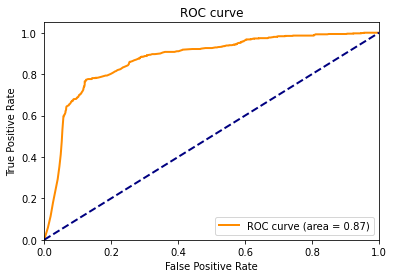

0.43585109719902543

In [52]:
acc_l, prepro_l, label_l = lr.sk_lr(file, "prediction", a, [])
lr.auc(label_l, prepro_l, "predict_model")

In [53]:
lr.evaluate(label_l, prepro_l, 0.5, int(1))

结果: 0.8329268292682926 0.8025889967637541 0.7654320987654321 0.7835703001579779


(0.8329268292682926,
 0.8025889967637541,
 0.7654320987654321,
 0.7835703001579779)